In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas
import xarray
import cftime
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

/Users/paulag/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
datapath = 'nino34_monthly.nc'
nino34 = xarray.open_dataset(datapath, decode_times = False)
print(nino34)
nino34 = np.array((nino34['nino34'].values)[12 * 50:])

<xarray.Dataset>
Dimensions:         (bounds: 2, month: 12, time: 7800)
Coordinates:
  * time            (time) float64 15.5 45.0 74.5 ... 2.372e+05 2.372e+05
Dimensions without coordinates: bounds, month
Data variables:
    nino34          (time) float64 ...
    time_bnds       (time, bounds) float64 ...
    areacello       float32 ...
    days_per_month  (month) int32 ...


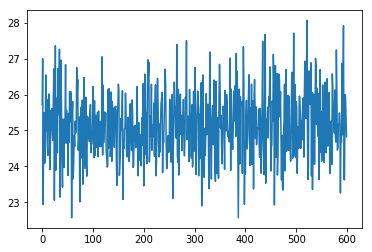

In [4]:
plt.plot(nino34[::12]);

In [5]:
def ONI(nino34, m = 3):
    oni = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        oni[i] = np.mean(nino34[max(0, (i - m + 1)) : min((i + 1), length)])
    return oni

In [6]:
oni = ONI(nino34)

In [7]:
def climatology(nino34):
    clm = np.zeros(12)
    length = nino34.shape[0]
    for month in range(12):
        section = [12 * i + month for i in range(length // 12)]
        clm[month] = np.mean(nino34[section])
    return clm

In [8]:
clm = climatology(nino34)

In [9]:
def SST_anomaly(nino34, clm):
    anm = np.array(nino34)
    length = nino34.shape[0]
    for i in range(length):
        anm[i] = nino34[i] - clm[i % 12]
    return anm

In [10]:
anm = SST_anomaly(nino34, clm)
oanm = ONI(anm)

# Data Preparation

In [11]:
T = 24      # prediction timeline
H = 48   # history used for prediction
signal = np.array(nino34)   # data used for training/testing
length = signal.shape[0]    # number of data points

mean = np.mean(signal)
std = np.std(signal)

signal = (signal - mean) / std

In [16]:
np.random.seed(0)

size = length - H - T       # effective dataset size
        
# create the 'history matrix'
data = np.ndarray((size, H))
for i in range(size):
    data[i] = signal[i:(i + H)]

labels = np.ndarray((size, T), dtype = np.float64)

for t in range(T):
    for i in range(size):
        labels[i,t] = anm[i + H + t]
        
labels[:, T // 2:] = np.random.randn(size, T // 2)

split = size // 10      
shuffle = np.random.permutation(size)
train_ind = np.array(shuffle[0: 8 * split])
val_ind = np.array(shuffle[8 * split: 9 * split])
test_ind = np.array(shuffle[9 * split: size])

train = np.array(data[train_ind])
train_labels = np.array(labels[train_ind])

val = np.array(data[val_ind])
val_labels = np.array(labels[val_ind])

test = np.array(data[test_ind])
test_labels = np.array(labels[test_ind])

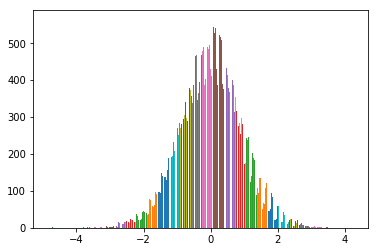

In [18]:
plt.hist(train_labels, bins=50);

# Simple Model

In [19]:
(N1, N2, N3, d) = (192, 768, 768, 0.5)
epochs = 60

mse_per_epoch = np.zeros(epochs)
mae_per_epoch = np.zeros(epochs)

model = tf.keras.models.Sequential([
                  tf.keras.layers.Dense(N1,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N2,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(N3,  kernel_initializer='normal', activation = tf.nn.relu),
                  tf.keras.layers.Dropout(d),
                  tf.keras.layers.Dense(T,  kernel_initializer='normal', activation = 'linear')
        ])

model.reset_states()

model.compile(optimizer='adam',
                    loss='mae',
                    metrics=['mse', 'mae'])

model.fit(train, train_labels, epochs = epochs, verbose = 1)
(loss, mse, mae) = model.evaluate(val, val_labels, verbose = 0)

print(mse, mae)

Epoch 1/60
5696/5696 [==============================] - 3s 528us/step - loss: 0.6697 - mean_squared_error: 0.7522 - mean_absolute_error: 0.6697
Epoch 2/60
5696/5696 [==============================] - 3s 466us/step - loss: 0.6462 - mean_squared_error: 0.7155 - mean_absolute_error: 0.6462
Epoch 3/60
5696/5696 [==============================] - 3s 439us/step - loss: 0.6394 - mean_squared_error: 0.7060 - mean_absolute_error: 0.6394
Epoch 4/60
5696/5696 [==============================] - 2s 396us/step - loss: 0.6314 - mean_squared_error: 0.6957 - mean_absolute_error: 0.6314
Epoch 5/60
5696/5696 [==============================] - 2s 398us/step - loss: 0.6257 - mean_squared_error: 0.6874 - mean_absolute_error: 0.6257
Epoch 6/60
5696/5696 [==============================] - 2s 391us/step - loss: 0.6195 - mean_squared_error: 0.6792 - mean_absolute_error: 0.6195
Epoch 7/60
5696/5696 [==============================] - 2s 437us/step - loss: 0.6120 - mean_squared_error: 0.6683 - mean_absolute_error:

5696/5696 [==============================] - 2s 370us/step - loss: 0.2119 - mean_squared_error: 0.1085 - mean_absolute_error: 0.2119
Epoch 58/60
5696/5696 [==============================] - 2s 342us/step - loss: 0.2089 - mean_squared_error: 0.1051 - mean_absolute_error: 0.2089
Epoch 59/60
5696/5696 [==============================] - 2s 334us/step - loss: 0.2063 - mean_squared_error: 0.1013 - mean_absolute_error: 0.2063
Epoch 60/60
5696/5696 [==============================] - 2s 401us/step - loss: 0.2036 - mean_squared_error: 0.0984 - mean_absolute_error: 0.2036
0.9036029737986876 0.6788416069545103


In [20]:
pred = model.predict(train)

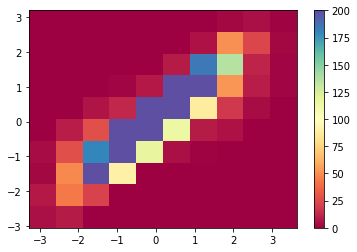

In [21]:
plt.hist2d(train_labels[:,-1], pred[:,-1], cmap = plt.cm.Spectral, vmax = 200);
plt.colorbar();

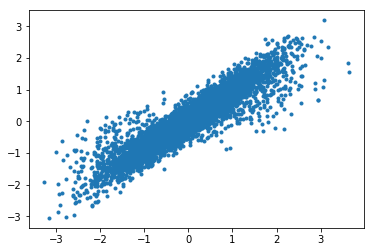

In [22]:
plt.plot(train_labels[:,-1], pred[:,-1], ".");

In [23]:
pred_val = model.predict(val)

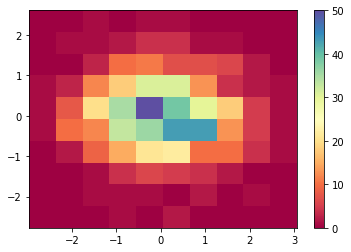

In [24]:
plt.hist2d(val_labels[:,-1], pred_val[:,-1], cmap = plt.cm.Spectral, vmax = 50);
plt.colorbar();

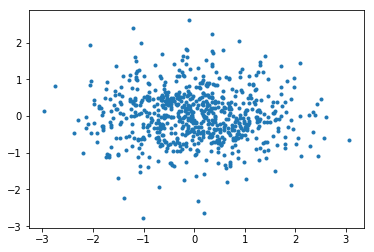

In [25]:
plt.plot(val_labels[:,-1], pred_val[:,-1], ".");

In [26]:
def correlation(x, y):
    x0 = x - np.mean(x, axis = 0)
    y0 = y - np.mean(y, axis = 0)
    return np.mean(x0 * y0, axis = 0) / np.sqrt((np.mean(x0**2, axis = 0) * (np.mean(y0**2, axis = 0))))

In [27]:
print(correlation(train_labels[:,-1], pred[:,-1]))
print(correlation(val_labels[:,-1], pred_val[:,-1]))

0.9212360501433232
-0.04394258528227582


In [28]:
print(correlation(val_labels, pred_val))

[ 0.93213729  0.91119102  0.88616391  0.86061175  0.83377869  0.80821797
  0.78939267  0.76834877  0.76062048  0.74203602  0.73282323  0.70842193
  0.04601698  0.02137645 -0.0371966   0.04739374  0.03478112  0.02161749
  0.05014202 -0.08200142  0.02907741  0.05399681 -0.01855998 -0.04394257]


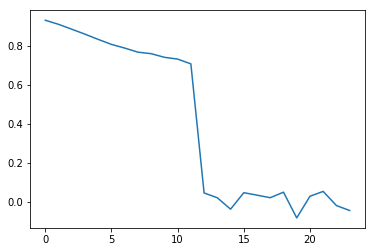

In [29]:
plt.plot(correlation(val_labels, pred_val));

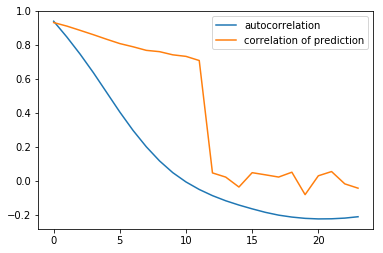

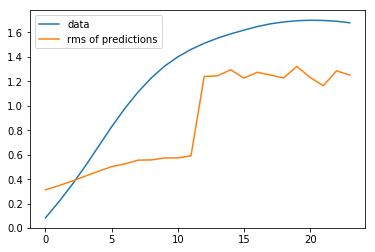

In [30]:
auto = np.zeros(T)
rms = np.zeros(T)

for t in range(T):
    auto[t] = correlation(anm[:(- t - 1)], anm[(t + 1):])
    rms[t] = mean_squared_error(anm[:(- t - 1)], anm[(t + 1):])
    
pred_rms = np.sqrt(((val_labels - pred_val)**2).mean(axis = 0))

plt.plot(auto, label = "autocorrelation");
plt.plot(correlation(val_labels, pred_val), label = "correlation of prediction");
plt.legend();
plt.figure();
plt.plot(rms, label = "data");
plt.plot(pred_rms, label = "rms of predictions")
plt.legend();